In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

2025-06-02 19:34:53.470817: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 19:34:56.127405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 19:35:03.564435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Model Import

In [2]:
num_segments=8
num_classes=34

model = tf.keras.models.load_model('mobile_tsm_bukva2')

2025-06-02 19:35:19.511860: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-02 19:35:27.265743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,56,56,144]
	 [[{{node x}}]]
2025-06-02 19:35:27.274801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,56,56,144]
	 [[{{node Placeholder}}]]
2025-06-02 19:35:27.353326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate a

### Data Import

In [3]:
label_map = {"no_event":0, "А":1, "Б":2, "В":3, "Г":4, "Д":5, "Е":6, "Ё":7, "Ж":8, "З":9, "И":10, "Й":11, "К":12, "Л":13, "М":14, "Н":15, "О":16, "П":17, "Р":18, "С":19, "Т":20, "У":21, "Ф":22, "Х":23, "Ц":24, "Ч":25, "Ш":26, "Щ":27, "Ъ":28, "Ы":29, "Ь":30, "Э":31, "Ю":32, "Я":33}

In [4]:
annot = pd.read_csv("/home/jupyter/datasphere/project/annotations.tsv", sep="\t")
annot.drop(columns=["user_id", "begin", "end", "height", "width", "length"], inplace=False)

annot["text"] = annot["text"].apply(lambda x: label_map[x])

In [5]:
test_df = annot[annot["train"] == False].drop("train", axis=1)
test_df.shape

(680, 8)

In [6]:
ROOT_DIR = "/home/jupyter/datasphere/project/processed"

### Dataset and Visualization Functions

In [7]:
def sample_frame_paths(video_dir, num_frames=8):

    all_frames = sorted([
        os.path.join(video_dir, fname)
        for fname in os.listdir(video_dir)
        if fname.endswith(".jpg")
    ])
    total = len(all_frames)

    boundaries = np.linspace(0, total, num_frames + 1, dtype=np.int32)
    
    selected_indices = []
    
    for i in range(num_frames):
        start = boundaries[i]
        end = boundaries[i + 1]
        if end - start > 0:
            idx = np.random.randint(start, end)
        else:
            idx = start
        selected_indices.append(idx)
    
    return [all_frames[i] for i in selected_indices]

In [8]:
def load_and_preprocess(path):
    
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    return tf.cast(img, tf.float32) / 255.0


In [9]:
def load_video(path, label):
        
    frame_paths = sample_frame_paths(path)

    frames = []
    for p in frame_paths:
        frames.append(load_and_preprocess(p))
    # frames.shape == (8, 224, 224, 3)
    frames = tf.stack(frames)
    return frames, label


In [10]:
def video_generator(df):
    
    list_video_dirs = df['attachment_id'].apply(lambda x: os.path.join(ROOT_DIR, x)).tolist()
    list_labels = tf.one_hot(df['text'].astype(np.int32).tolist(), 34)
    for path, label in zip(list_video_dirs, list_labels):
        frames, _ = load_video(path, label)
        yield frames, label


def create_validation_dataset(df, batch_size=8, augment=False, shuffle=False):

    dataset = tf.data.Dataset.from_generator(
        lambda: video_generator(df),
        output_signature=(
            tf.TensorSpec(shape=(8, 224, 224, 3)),
            tf.TensorSpec(shape=(34,), dtype=tf.float32)
        ))
    
    dataset = dataset.batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [11]:
def get_actual_predicted_labels(dataset):
    
    actual = test_df["text"].to_list()
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

In [12]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    sns.set(rc={"figure.figsize": (20, 20)})
    sns.set(font_scale=1.4)
    ax.set_title("Confusion matrix of action recognition for " + ds_type)
    ax.set_xlabel("Predicted Action")
    ax.set_ylabel("Actual Action")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    fig = ax.get_figure()
    fig.savefig("out.png") 

In [13]:
batch_size = 16

valid_ds = create_validation_dataset(test_df, batch_size)

### Diagrams and Evaluation

In [14]:
actual, predicted = get_actual_predicted_labels(valid_ds)

2025-06-02 19:35:28.733039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


43/43 [==============================] - 69s 2s/step


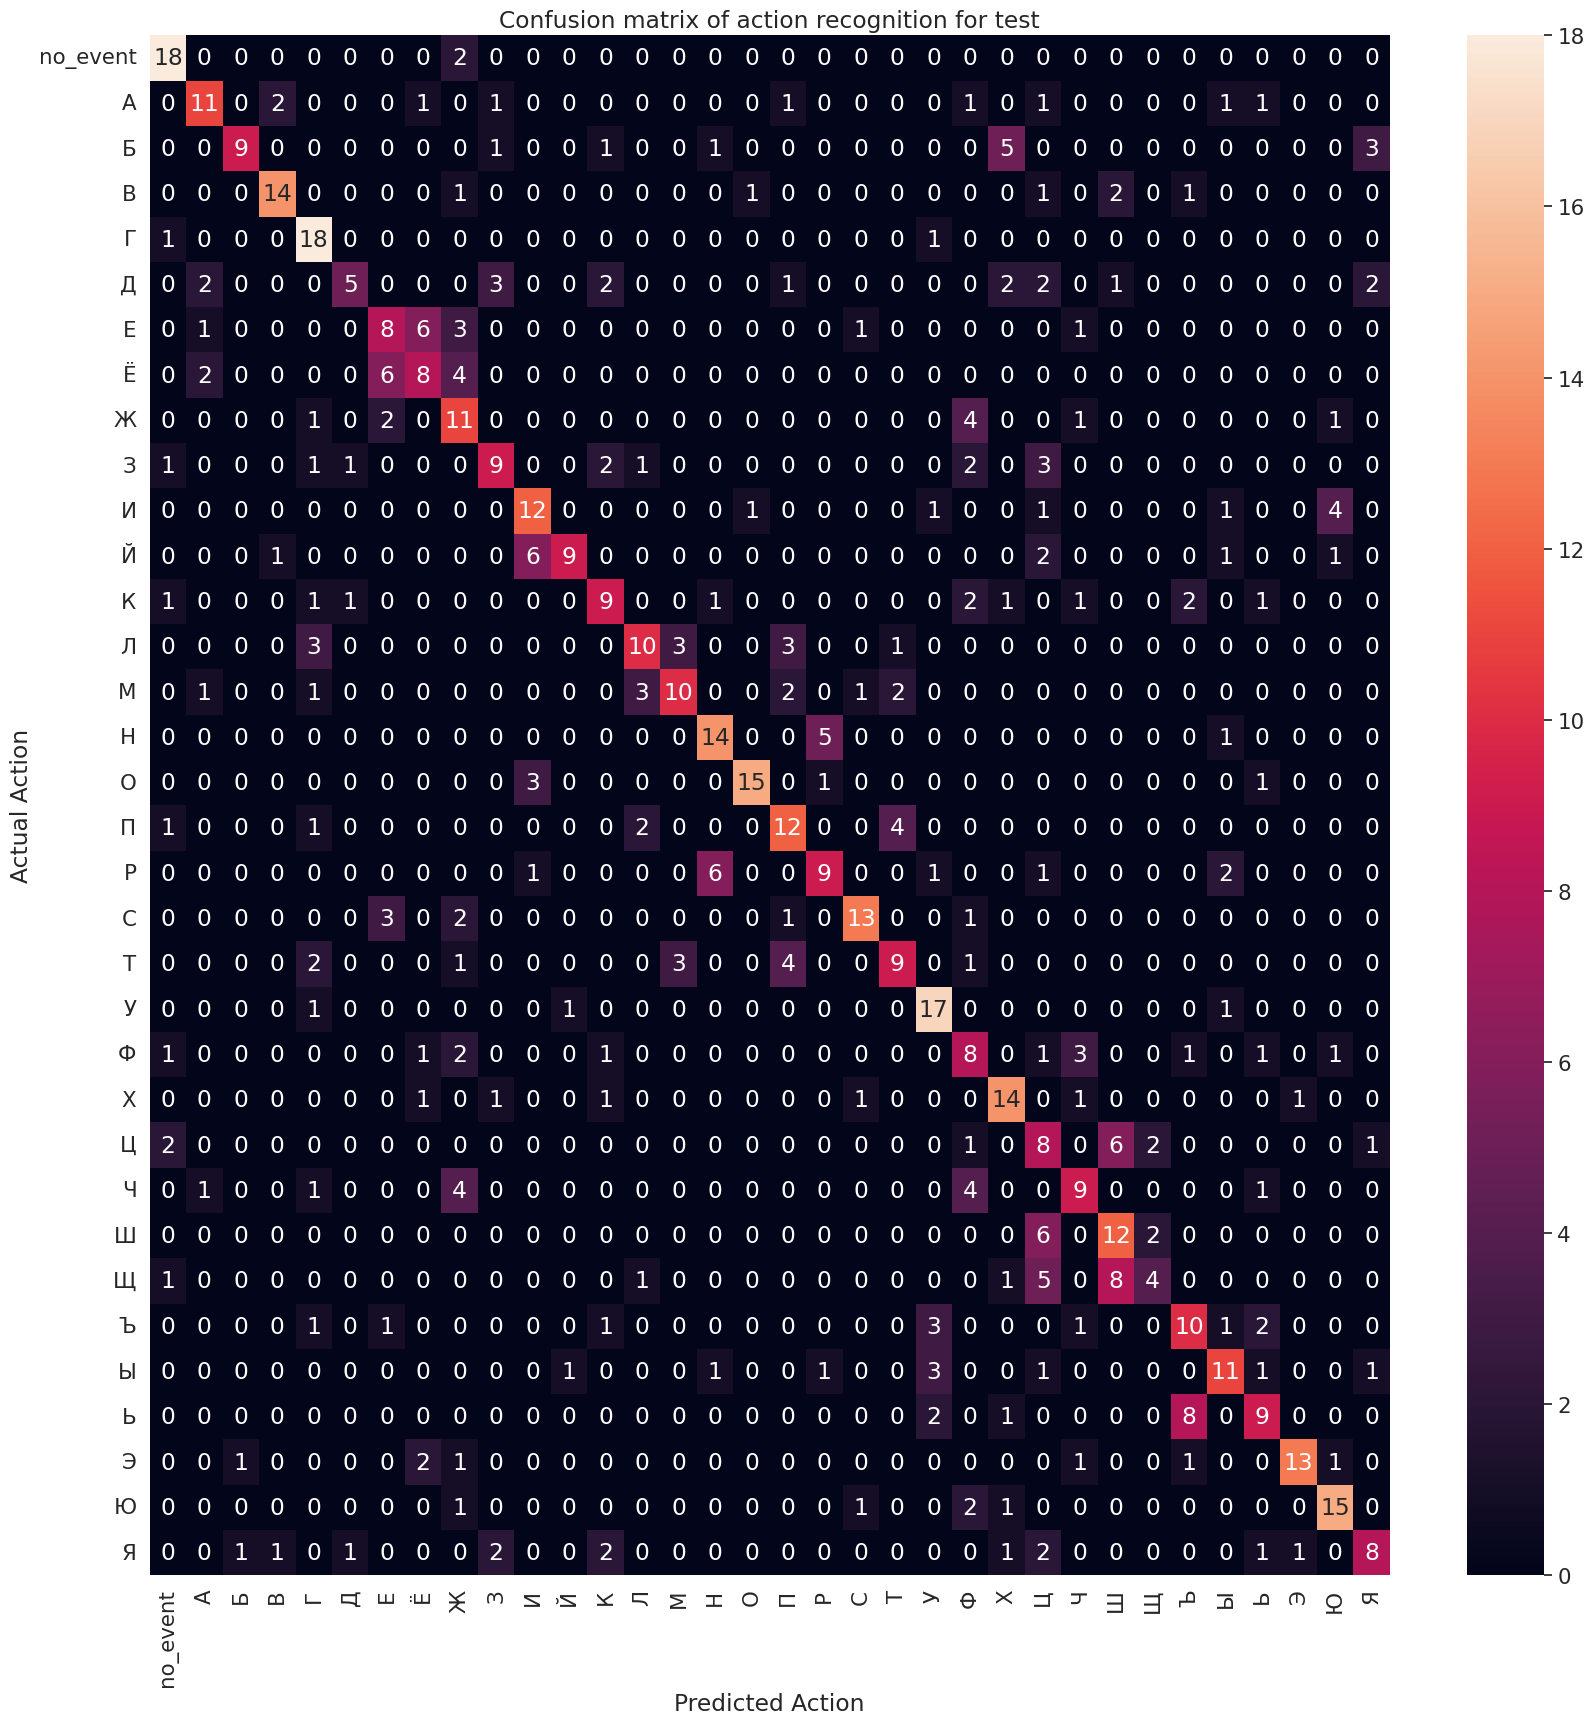

In [16]:
plot_confusion_matrix(actual, predicted, list(label_map.keys()), 'test')

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [18]:
test_accuracy = accuracy_score(predicted, actual)
print(f'Accuracy on test data: {test_accuracy}')

Accuracy on test data: 0.5455882352941176


In [19]:
print(classification_report(actual, predicted, target_names=list(label_map.keys())))

              precision    recall  f1-score   support

    no_event       0.69      0.90      0.78        20
           А       0.61      0.55      0.58        20
           Б       0.82      0.45      0.58        20
           В       0.78      0.70      0.74        20
           Г       0.58      0.90      0.71        20
           Д       0.62      0.25      0.36        20
           Е       0.40      0.40      0.40        20
           Ё       0.42      0.40      0.41        20
           Ж       0.34      0.55      0.42        20
           З       0.53      0.45      0.49        20
           И       0.55      0.60      0.57        20
           Й       0.82      0.45      0.58        20
           К       0.47      0.45      0.46        20
           Л       0.59      0.50      0.54        20
           М       0.62      0.50      0.56        20
           Н       0.61      0.70      0.65        20
           О       0.88      0.75      0.81        20
           П       0.50    